In [1]:
# import torch
# import torchvision
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt
import numpy as np
# import pylab
from datetime import datetime

# import os
# import math
# import random
import pandas as pd
# import itertools
from scipy.io import loadmat
# from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import h5py
from torch.utils.data.dataset import Dataset
# import glob3 as glob

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.3.1
Torchvision Version:  0.4.2


In [3]:

torch.cuda.is_available()

True

In [4]:
import torchvision.models as models
import torch.nn as nn
resnet = models.resnet18()

In [5]:

model_name = "resnet"

# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 512

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [6]:
# #Rasnet18
# resnet.conv1 = nn.Conv2d(in_channels=40, out_channels=64, kernel_size=7,stride=2, padding=3, bias=False)
# resnet.fc = nn.Linear(2048, num_classes)

In [7]:
def train_model(model, dataloaders, criterion, optimizer, optimizer2, num_epochs=25, is_inception=False):
    since = time.time()
    start = datetime.now()
    val_acc_history = []
    train_acc_history = []
    val_Bacc_history = []
    train_Bacc_history = []
    val_loss_history = []
    train_loss_history = []
    lr_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 1e10
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=0, eps=1e-08)
    scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=0, eps=1e-08)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if epoch < 5:
                    for param_group in optimizer.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                else:
                    for param_group in optimizer2.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            epoch_samples = 0
            confusion_matrix = torch.zeros(3, 3)
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.type(torch.FloatTensor)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                if epoch < 5:
                    optimizer.zero_grad()
                else:
                    optimizer2.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                     # statistics
                    epoch_samples += inputs.size(0)
                    # statistics
                    for t, p in zip(labels.view(-1), preds.view(-1)):
                        confusion_matrix[t.long(), p.long()] += 1

                    running_corrects += torch.sum(preds == labels.data)


                confusionMat = np.asarray(confusion_matrix)
                sumconfusion = np.sum(confusionMat,axis = 1).T

                summat = np.tile(sumconfusion,(3,1)).T
                # print(test)
                percentconfusion = np.divide(confusionMat,summat)
                epoch_acc_balanced = np.sum(np.diagonal(percentconfusion))/3

                # statistics
                running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
        

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Bal. Acc: {:.4f}'.format(phase, epoch_acc_balanced))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                print("saving best model")
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_loss = epoch_loss
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_Bacc_history.append(epoch_acc_balanced)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_Bacc_history.append(epoch_acc_balanced)
                train_loss_history.append(epoch_loss)
#             if epoch_acc == 1:
#                 break
            
        print("Total time: %s" %(datetime.now() - start))
        time_elapsed = time.time() - since
        print('Epoch time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print()
        if epoch < 5:
            scheduler.step(epoch_loss)
        else:
            scheduler2.step(epoch_loss)
#         if epoch >= 6  and val_loss_history [-1] >= val_loss_history [-2] >= val_loss_history [-3] >= val_loss_history[-4]>=val_loss_history[-5]>=val_loss_history[-6]:
#             break
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history,train_acc_history,train_loss_history, val_loss_history,lr_history,train_Bacc_history,val_Bacc_history

In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [9]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.conv1 = nn.Conv2d(in_channels=80, out_channels=64, kernel_size=7,stride=2, padding=3, bias=False)
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 80
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(80, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [10]:

x = torch.randn(4, 80, 80,80)

# Let's print it
outputs = model_ft(x)
print(outputs)

model_ft

tensor([[ 0.2099,  0.8014, -0.3610],
        [ 0.3809, -0.0444,  0.3204],
        [ 0.7385, -0.1687, -0.0748],
        [ 0.5201, -1.2638,  0.3603]], grad_fn=<AddmmBackward>)


ResNet(
  (conv1): Conv2d(80, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [11]:
Datadir = "H:\\CellLineClassification\\3DImages\\3DImages"

In [12]:
import os

def datapreparation(Datadir):
    trainpath = []
    trainlabel = []
    fpath = []
    traindir = Datadir + "\\HEK"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('HEK data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])
        trainlabel.append(0)

    fpath = []
    traindir = Datadir + "\\HELA"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('HELA data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i]) 
        trainlabel.append(1)

    fpath = []
    traindir = Datadir + "\\MCF7"
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('MCF7 data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])
        trainlabel.append(2)
    return trainpath,trainlabel

In [13]:
X, Y = datapreparation(Datadir)

HEK data: 3191
HELA data: 3315
MCF7 data: 3764


In [14]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
trainindex = {}
testindex = {}
i = 0
for train_index, test_index in kfold.split(X,Y):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)
    trainindex[i] = train_index
    testindex[i] = test_index
    i = i + 1
#fold - 0
# print(trainindex[1])
# indices = trainindex[1]
trainpath =[X[i] for i in trainindex[1]]
testpath =[X[i] for i in testindex[1]]

Train Index:  [    0     1     2 ... 10267 10268 10269] 

Test Index:  [    3     5     6 ... 10262 10263 10264]
Train Index:  [    3     5     6 ... 10266 10267 10269] 

Test Index:  [    0     1     2 ... 10258 10259 10268]
Train Index:  [    0     1     2 ... 10267 10268 10269] 

Test Index:  [    9    10    11 ... 10249 10253 10265]
Train Index:  [    0     1     2 ... 10266 10268 10269] 

Test Index:  [    7    13    17 ... 10252 10257 10267]
Train Index:  [    0     1     2 ... 10265 10267 10268] 

Test Index:  [   20    21    27 ... 10255 10266 10269]


In [15]:
from skimage import io
import skimage.transform
import scipy
class MyDataset(Dataset):
    def __init__(self, mat_paths, transforms=None):
        self.paths = mat_paths
        self.transforms = transforms
        
    def __getitem__(self, index):
        # Load .mat
#         data = loadmat(self.paths[index])
        data = io.imread(self.paths[index])
#         reshape = skimage.transform.resize(data,(224,224,40))
#         x = torch.from_numpy(reshape.astype(np.float32))
        x = torch.from_numpy(data.astype(np.float32)/65535)
        x = np.transpose(x,(2,0,1))
#         x = np.transpose(np.array(data['Data']),(2,0,1))
        if 'HEK' in self.paths[index]:
            label = int(0)
        elif 'HELA' in self.paths[index]:
            label = int(1)
        elif 'MCF7' in self.paths[index]:
            label = int(2)
        if self.transforms:
            x= self.transforms(x)
        return x,label
    
    def __len__(self):
        return len(self.paths)

In [16]:
#actual training
image_datasets = {}
mini_datasets ={}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(testpath)
# mini_datasets['train'] = MyDataset(minitrainpath)
# mini_datasets['val'] = MyDataset(minivalpath)
# model testing
# image_datasets['train'] = MyDataset(valpath)
# image_datasets['val'] = MyDataset(testpath)
# test_datasets['val'] = MyDataset(testpath)
print('training data volume: ', image_datasets['train'].__len__())
print('validation data volume: ', image_datasets['val'].__len__())

# print('mini-training data volume: ', mini_datasets['train'].__len__())
# print('mini-validation data volume: ', mini_datasets['val'].__len__())

CellName = ['HEK','HELA','MCF7']
image_datasets['train'].__getitem__(0)[0].shape
[ImgTensor,ImgLabel] = image_datasets['train'].__getitem__(0)
print('Cell Label: ',CellName[ImgLabel])
print('image tensor shape: ', ImgTensor.shape)
print('image tensor dtype: ', ImgTensor.dtype)
image_datasets['train'].__getitem__(0)[0]

#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
image = np.squeeze(ImgTensor.numpy())
print('image shape: ', image.shape)

training data volume:  8216
validation data volume:  2054
Cell Label:  HEK
image tensor shape:  torch.Size([80, 80, 80])
image tensor dtype:  torch.float32
image shape:  (80, 80, 80)


C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


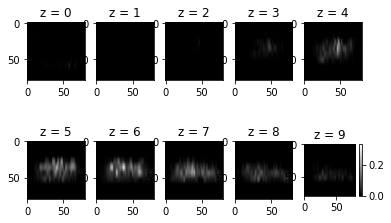

In [17]:
#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
image = np.transpose(ImgTensor.numpy(), (1,2,0))

def DisplayImage(img,LimMin,LimMax):  
    if img.shape[2]>1:
        for depth in range (0,10):
            plt.subplot(2,5,depth+1)
            plt.imshow(img[:,:,depth*8],vmin=LimMin, vmax=LimMax, cmap ='gray')
            # plt.colorbar()
            plt.title('z = '+ str(depth))
            if depth==9:
                plt.subplot(2,5,depth+1)
                plt.title('z = '+ str(depth))
                ax = plt.gca()
                fig4 = plt.imshow(img[:,:,depth*8],vmin=LimMin, vmax=LimMax, cmap ='gray')

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(fig4, cax=cax)
        plt.show()
    else:
        fig4 = plt.imshow(np.squeeze(img),vmin=LimMin, vmax=LimMax, cmap ='gray')
        plt.title('2D Projection')
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(fig4, cax=cax)
        plt.show()
DisplayImage(image,image.min(),image.max())

In [18]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
#         transforms.RandomResizedCrop(input_size),
        transforms.Resize(input_size),
#         transforms.RandomHorizontalFlip(),
#         transforms.CenterCrop(input_size),
        transforms.ToTensor(),
#         transforms.Normalize([0.00351, 0.00351, 0.00351], [0.009389, 0.009389, 0.009389])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
#         transforms.CenterCrop(input_size),
        transforms.ToTensor(),
#         transforms.Normalize([0.00351, 0.00351, 0.00351], [0.009389, 0.009389, 0.009389])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


Fold- 0 : Initializing Datasets and Dataloaders...
Epoch 0/99
----------
LR 5e-06
train Loss: 1.0580 Acc: 0.4332
train Bal. Acc: 0.4541
val Loss: 1.1347 Acc: 0.3111
val Bal. Acc: 0.3333
saving best model
Total time: 0:02:49.819972
Epoch time: 2m 50s

Epoch 1/99
----------
LR 5e-06
train Loss: 0.9571 Acc: 0.5072
train Bal. Acc: 0.5313
val Loss: 1.2346 Acc: 0.3111
val Bal. Acc: 0.3333
Total time: 0:05:38.189973
Epoch time: 5m 38s

Epoch 2/99
----------
LR 5e-06
train Loss: 0.9074 Acc: 0.5727
train Bal. Acc: 0.5883
val Loss: 1.1291 Acc: 0.3418
val Bal. Acc: 0.3639
saving best model
Total time: 0:08:25.981970
Epoch time: 8m 26s

Epoch 3/99
----------
LR 5e-06
train Loss: 0.8725 Acc: 0.6150
train Bal. Acc: 0.6226
val Loss: 0.9279 Acc: 0.5467
val Bal. Acc: 0.5590
saving best model
Total time: 0:11:14.059970
Epoch time: 11m 14s

Epoch 4/99
----------
LR 5e-06
train Loss: 0.8414 Acc: 0.6334
train Bal. Acc: 0.6375
val Loss: 0.8604 Acc: 0.6168
val Bal. Acc: 0.6229
saving best model
Total time: 0

val Loss: 0.3786 Acc: 0.8564
val Bal. Acc: 0.8559
Total time: 1:57:36.345970
Epoch time: 117m 36s

Epoch 42/99
----------
LR 5e-05
train Loss: 0.1038 Acc: 0.9816
train Bal. Acc: 0.9815
val Loss: 0.3804 Acc: 0.8505
val Bal. Acc: 0.8513
Total time: 2:00:24.687970
Epoch time: 120m 25s

Epoch 43/99
----------
LR 5e-05
train Loss: 0.0906 Acc: 0.9856
train Bal. Acc: 0.9853
val Loss: 0.3775 Acc: 0.8598
val Bal. Acc: 0.8601
Total time: 2:03:12.704971
Epoch time: 123m 13s

Epoch 44/99
----------
LR 5e-05
train Loss: 0.0853 Acc: 0.9876
train Bal. Acc: 0.9873
val Loss: 0.3816 Acc: 0.8583
val Bal. Acc: 0.8585
Total time: 2:06:01.005973
Epoch time: 126m 1s

Epoch    39: reducing learning rate of group 0 to 2.5000e-05.
Epoch 45/99
----------
LR 2.5e-05
train Loss: 0.0801 Acc: 0.9881
train Bal. Acc: 0.9878
val Loss: 0.3820 Acc: 0.8549
val Bal. Acc: 0.8540
Total time: 2:08:49.139972
Epoch time: 128m 49s

Epoch 46/99
----------
LR 2.5e-05
train Loss: 0.0740 Acc: 0.9903
train Bal. Acc: 0.9901
val Loss: 

train Loss: 0.0190 Acc: 0.9993
train Bal. Acc: 0.9993
val Loss: 0.4393 Acc: 0.8612
val Bal. Acc: 0.8597
Total time: 3:54:46.837970
Epoch time: 234m 47s

Epoch 84/99
----------
LR 7.8125e-07
train Loss: 0.0507 Acc: 0.9884
train Bal. Acc: 0.9888
val Loss: 0.4437 Acc: 0.8569
val Bal. Acc: 0.8567
Total time: 3:57:34.692971
Epoch time: 237m 35s

Epoch 85/99
----------
LR 7.8125e-07
train Loss: 0.0258 Acc: 0.9971
train Bal. Acc: 0.9972
val Loss: 0.5241 Acc: 0.8296
val Bal. Acc: 0.8360
Total time: 4:00:22.724971
Epoch time: 240m 23s

Epoch 86/99
----------
LR 7.8125e-07
train Loss: 0.0175 Acc: 0.9998
train Bal. Acc: 0.9997
val Loss: 0.4247 Acc: 0.8549
val Bal. Acc: 0.8555
Total time: 4:03:10.949971
Epoch time: 243m 11s

Epoch    81: reducing learning rate of group 0 to 3.9063e-07.
Epoch 87/99
----------
LR 3.90625e-07
train Loss: 0.0130 Acc: 1.0000
train Bal. Acc: 1.0000
val Loss: 0.4312 Acc: 0.8583
val Bal. Acc: 0.8593
Total time: 4:05:58.871977
Epoch time: 245m 59s

Epoch 88/99
----------
L

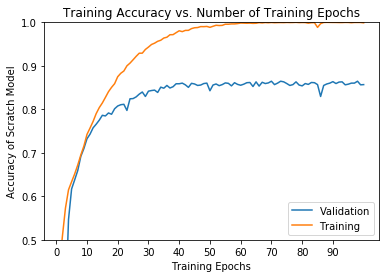

100


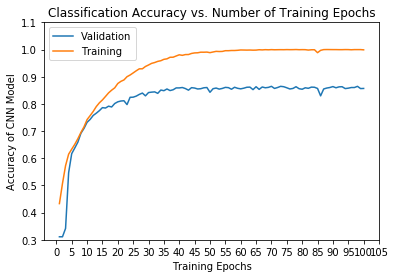

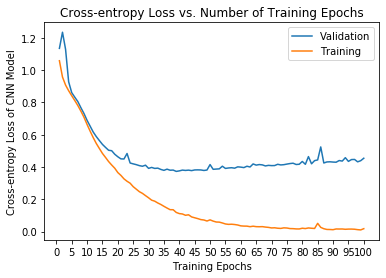

tensor([[581.,  34.,  24.],
        [ 32., 538.,  93.],
        [ 19.,  76., 657.]])
[632. 648. 774.]
[[0.90923315 0.05320814 0.03755869]
 [0.04826546 0.81146306 0.1402715 ]
 [0.02526596 0.10106383 0.8736702 ]]



Fold- 1 : Initializing Datasets and Dataloaders...


C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type "

Epoch 0/99
----------
LR 5e-06
train Loss: 1.0509 Acc: 0.4253
train Bal. Acc: 0.4425
val Loss: 1.1813 Acc: 0.3106
val Bal. Acc: 0.3333
saving best model
Total time: 0:02:45.537000
Epoch time: 2m 46s

Epoch 1/99
----------
LR 5e-06
train Loss: 0.9582 Acc: 0.5443
train Bal. Acc: 0.5585
val Loss: 1.3112 Acc: 0.3116
val Bal. Acc: 0.3343
saving best model
Total time: 0:05:31.262001
Epoch time: 5m 31s

Epoch 2/99
----------
LR 5e-06
train Loss: 0.9163 Acc: 0.5850
train Bal. Acc: 0.5930
val Loss: 1.1452 Acc: 0.3632
val Bal. Acc: 0.3830
saving best model
Total time: 0:08:20.931999
Epoch time: 8m 21s

Epoch 3/99
----------
LR 5e-06
train Loss: 0.8822 Acc: 0.6106
train Bal. Acc: 0.6151
val Loss: 0.9381 Acc: 0.5750
val Bal. Acc: 0.5842
saving best model
Total time: 0:11:06.118000
Epoch time: 11m 6s

Epoch 4/99
----------
LR 5e-06
train Loss: 0.8512 Acc: 0.6353
train Bal. Acc: 0.6378
val Loss: 0.8725 Acc: 0.6237
val Bal. Acc: 0.6261
saving best model
Total time: 0:13:51.256000
Epoch time: 13m 51s


train Loss: 0.1108 Acc: 0.9814
train Bal. Acc: 0.9810
val Loss: 0.4114 Acc: 0.8515
val Bal. Acc: 0.8535
saving best model
Total time: 1:59:42.056000
Epoch time: 119m 42s

Epoch 43/99
----------
LR 2.5e-05
train Loss: 0.1148 Acc: 0.9780
train Bal. Acc: 0.9775
val Loss: 0.4197 Acc: 0.8418
val Bal. Acc: 0.8406
Total time: 2:02:30.262999
Epoch time: 122m 30s

Epoch 44/99
----------
LR 2.5e-05
train Loss: 0.1038 Acc: 0.9824
train Bal. Acc: 0.9820
val Loss: 0.4073 Acc: 0.8466
val Bal. Acc: 0.8459
Total time: 2:05:26.783000
Epoch time: 125m 27s

Epoch 45/99
----------
LR 2.5e-05
train Loss: 0.0951 Acc: 0.9847
train Bal. Acc: 0.9843
val Loss: 0.4104 Acc: 0.8520
val Bal. Acc: 0.8527
saving best model
Total time: 2:08:11.791999
Epoch time: 128m 12s

Epoch 46/99
----------
LR 2.5e-05
train Loss: 0.0871 Acc: 0.9880
train Bal. Acc: 0.9877
val Loss: 0.4141 Acc: 0.8491
val Bal. Acc: 0.8497
Total time: 2:10:57.564999
Epoch time: 130m 58s

Epoch 47/99
----------
LR 2.5e-05
train Loss: 0.0846 Acc: 0.987

val Loss: 0.4726 Acc: 0.8437
val Bal. Acc: 0.8425
Total time: 3:54:00.532000
Epoch time: 234m 1s

Epoch 84/99
----------
LR 7.8125e-07
train Loss: 0.0186 Acc: 0.9999
train Bal. Acc: 0.9999
val Loss: 0.4537 Acc: 0.8544
val Bal. Acc: 0.8564
Total time: 3:56:49.016999
Epoch time: 236m 49s

Epoch 85/99
----------
LR 7.8125e-07
train Loss: 0.0216 Acc: 0.9978
train Bal. Acc: 0.9977
val Loss: 0.4836 Acc: 0.8423
val Bal. Acc: 0.8405
Total time: 3:59:37.264999
Epoch time: 239m 37s

Epoch    80: reducing learning rate of group 0 to 3.9063e-07.
Epoch 86/99
----------
LR 3.90625e-07
train Loss: 0.0174 Acc: 0.9994
train Bal. Acc: 0.9994
val Loss: 0.4527 Acc: 0.8505
val Bal. Acc: 0.8524
Total time: 4:02:23.346003
Epoch time: 242m 23s

Epoch 87/99
----------
LR 3.90625e-07
train Loss: 0.0167 Acc: 0.9994
train Bal. Acc: 0.9994
val Loss: 0.4535 Acc: 0.8530
val Bal. Acc: 0.8539
Total time: 4:05:09.307223
Epoch time: 245m 9s

Epoch 88/99
----------
LR 3.90625e-07
train Loss: 0.0144 Acc: 1.0000
train Bal.

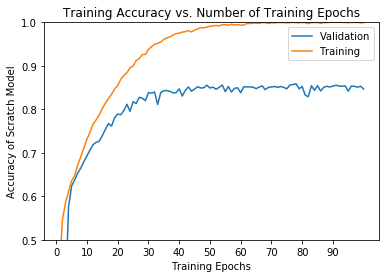

100


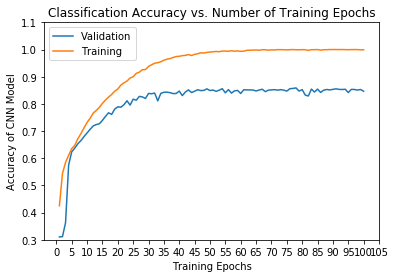

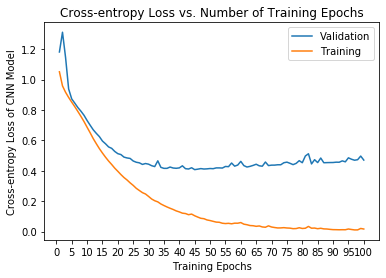

tensor([[596.,  21.,  21.],
        [ 48., 538.,  77.],
        [ 32.,  91., 630.]])
[676. 650. 728.]
[[0.9341693  0.03291536 0.03291536]
 [0.07239819 0.81146306 0.11613876]
 [0.04249668 0.12084994 0.8366534 ]]



Fold- 2 : Initializing Datasets and Dataloaders...
Epoch 0/99
----------
LR 5e-06
train Loss: 1.1722 Acc: 0.3825
train Bal. Acc: 0.3958
val Loss: 1.1520 Acc: 0.3106
val Bal. Acc: 0.3333
saving best model
Total time: 0:02:48.413969
Epoch time: 2m 48s

Epoch 1/99
----------
LR 5e-06
train Loss: 0.9915 Acc: 0.5324
train Bal. Acc: 0.5447
val Loss: 1.2925 Acc: 0.3106
val Bal. Acc: 0.3333
Total time: 0:05:36.703969
Epoch time: 5m 37s

Epoch 2/99
----------
LR 5e-06
train Loss: 0.9444 Acc: 0.5801
train Bal. Acc: 0.5896
val Loss: 1.2383 Acc: 0.3306
val Bal. Acc: 0.3524
saving best model
Total time: 0:08:24.313968
Epoch time: 8m 24s

Epoch 3/99
----------
LR 5e-06
train Loss: 0.9065 Acc: 0.6013
train Bal. Acc: 0.6066
val Loss: 1.0065 Acc: 0.5063
val Bal. Acc: 0.5172
saving best model


train Loss: 0.1182 Acc: 0.9763
train Bal. Acc: 0.9758
val Loss: 0.3266 Acc: 0.8724
val Bal. Acc: 0.8704
Total time: 1:56:39.293969
Epoch time: 116m 39s

Epoch 42/99
----------
LR 5e-05
train Loss: 0.1141 Acc: 0.9791
train Bal. Acc: 0.9790
val Loss: 0.3305 Acc: 0.8812
val Bal. Acc: 0.8821
Total time: 1:59:24.796970
Epoch time: 119m 25s

Epoch 43/99
----------
LR 5e-05
train Loss: 0.1113 Acc: 0.9788
train Bal. Acc: 0.9785
val Loss: 0.3315 Acc: 0.8681
val Bal. Acc: 0.8702
Total time: 2:02:10.044969
Epoch time: 122m 10s

Epoch 44/99
----------
LR 5e-05
train Loss: 0.1049 Acc: 0.9798
train Bal. Acc: 0.9793
val Loss: 0.3178 Acc: 0.8783
val Bal. Acc: 0.8777
Total time: 2:04:55.771969
Epoch time: 124m 56s

Epoch 45/99
----------
LR 5e-05
train Loss: 0.1001 Acc: 0.9834
train Bal. Acc: 0.9832
val Loss: 0.3163 Acc: 0.8802
val Bal. Acc: 0.8799
Total time: 2:07:41.438968
Epoch time: 127m 41s

Epoch 46/99
----------
LR 5e-05
train Loss: 0.1019 Acc: 0.9793
train Bal. Acc: 0.9790
val Loss: 0.3180 Acc:

train Loss: 0.0171 Acc: 0.9995
train Bal. Acc: 0.9995
val Loss: 0.3535 Acc: 0.8700
val Bal. Acc: 0.8728
Total time: 3:54:11.608969
Epoch time: 234m 12s

Epoch 84/99
----------
LR 1.5625e-06
train Loss: 0.0350 Acc: 0.9933
train Bal. Acc: 0.9932
val Loss: 0.3670 Acc: 0.8734
val Bal. Acc: 0.8711
Total time: 3:56:57.121968
Epoch time: 236m 57s

Epoch 85/99
----------
LR 1.5625e-06
train Loss: 0.0236 Acc: 0.9984
train Bal. Acc: 0.9984
val Loss: 0.4624 Acc: 0.8539
val Bal. Acc: 0.8488
Total time: 3:59:42.594973
Epoch time: 239m 43s

Epoch 86/99
----------
LR 1.5625e-06
train Loss: 0.0263 Acc: 0.9966
train Bal. Acc: 0.9967
val Loss: 0.5591 Acc: 0.8130
val Bal. Acc: 0.8212
Total time: 4:02:28.091968
Epoch time: 242m 28s

Epoch    81: reducing learning rate of group 0 to 7.8125e-07.
Epoch 87/99
----------
LR 7.8125e-07
train Loss: 0.0266 Acc: 0.9978
train Bal. Acc: 0.9977
val Loss: 0.3394 Acc: 0.8822
val Bal. Acc: 0.8815
Total time: 4:05:13.427968
Epoch time: 245m 13s

Epoch 88/99
----------
LR

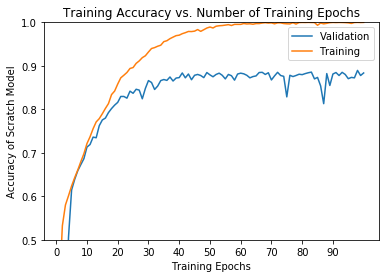

100


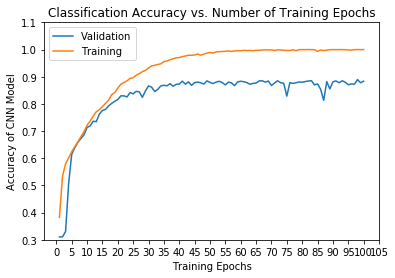

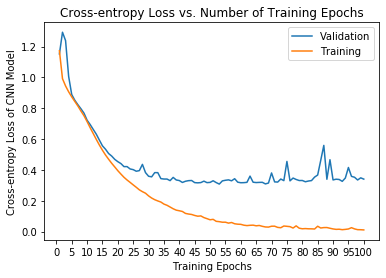

tensor([[578.,  38.,  22.],
        [ 30., 550.,  83.],
        [  8.,  46., 699.]])
[616. 634. 804.]
[[0.9059561  0.05956113 0.03448276]
 [0.04524887 0.8295626  0.12518854]
 [0.01062417 0.06108898 0.92828685]]



Fold- 3 : Initializing Datasets and Dataloaders...
Epoch 0/99
----------
LR 5e-06
train Loss: 1.0772 Acc: 0.4124
train Bal. Acc: 0.4371
val Loss: 1.1355 Acc: 0.3106
val Bal. Acc: 0.3333
saving best model
Total time: 0:02:48.224970
Epoch time: 2m 48s

Epoch 1/99
----------
LR 5e-06
train Loss: 0.9719 Acc: 0.5090
train Bal. Acc: 0.5332
val Loss: 1.1941 Acc: 0.3111
val Bal. Acc: 0.3338
saving best model
Total time: 0:05:36.770976
Epoch time: 5m 37s

Epoch 2/99
----------
LR 5e-06
train Loss: 0.9223 Acc: 0.5652
train Bal. Acc: 0.5829
val Loss: 1.0834 Acc: 0.3734
val Bal. Acc: 0.3963
saving best model
Total time: 0:08:24.674969
Epoch time: 8m 25s

Epoch 3/99
----------
LR 5e-06
train Loss: 0.8827 Acc: 0.6116
train Bal. Acc: 0.6221
val Loss: 0.9229 Acc: 0.5677
val Bal. Acc: 0.5785


train Loss: 0.1219 Acc: 0.9766
train Bal. Acc: 0.9763
val Loss: 0.4332 Acc: 0.8398
val Bal. Acc: 0.8410
saving best model
Total time: 1:54:11.273968
Epoch time: 114m 11s

Epoch 41/99
----------
LR 5e-05
train Loss: 0.1127 Acc: 0.9805
train Bal. Acc: 0.9801
val Loss: 0.4380 Acc: 0.8408
val Bal. Acc: 0.8431
saving best model
Total time: 1:57:03.626969
Epoch time: 117m 4s

Epoch 42/99
----------
LR 5e-05
train Loss: 0.1094 Acc: 0.9800
train Bal. Acc: 0.9795
val Loss: 0.4422 Acc: 0.8320
val Bal. Acc: 0.8297
Total time: 1:59:52.051968
Epoch time: 119m 52s

Epoch 43/99
----------
LR 5e-05
train Loss: 0.0968 Acc: 0.9837
train Bal. Acc: 0.9834
val Loss: 0.4333 Acc: 0.8403
val Bal. Acc: 0.8402
Total time: 2:02:39.879969
Epoch time: 122m 40s

Epoch 44/99
----------
LR 5e-05
train Loss: 0.0977 Acc: 0.9853
train Bal. Acc: 0.9850
val Loss: 0.4298 Acc: 0.8437
val Bal. Acc: 0.8422
saving best model
Total time: 2:05:27.921969
Epoch time: 125m 28s

Epoch 45/99
----------
LR 5e-05
train Loss: 0.0932 Acc

train Loss: 0.0150 Acc: 1.0000
train Bal. Acc: 1.0000
val Loss: 0.4734 Acc: 0.8447
val Bal. Acc: 0.8440
Total time: 3:51:36.043988
Epoch time: 231m 36s

Epoch 83/99
----------
LR 1.5625e-06
train Loss: 0.0140 Acc: 0.9998
train Bal. Acc: 0.9998
val Loss: 0.4707 Acc: 0.8500
val Bal. Acc: 0.8500
Total time: 3:54:24.334988
Epoch time: 234m 24s

Epoch 84/99
----------
LR 1.5625e-06
train Loss: 0.0138 Acc: 1.0000
train Bal. Acc: 1.0000
val Loss: 0.4741 Acc: 0.8476
val Bal. Acc: 0.8486
Total time: 3:57:12.852990
Epoch time: 237m 13s

Epoch 85/99
----------
LR 1.5625e-06
train Loss: 0.0141 Acc: 1.0000
train Bal. Acc: 1.0000
val Loss: 0.4777 Acc: 0.8505
val Bal. Acc: 0.8525
Total time: 4:00:01.567986
Epoch time: 240m 2s

Epoch 86/99
----------
LR 1.5625e-06
train Loss: 0.0137 Acc: 0.9998
train Bal. Acc: 0.9998
val Loss: 0.4743 Acc: 0.8500
val Bal. Acc: 0.8515
Total time: 4:02:49.988988
Epoch time: 242m 50s

Epoch    81: reducing learning rate of group 0 to 7.8125e-07.
Epoch 87/99
----------
LR 

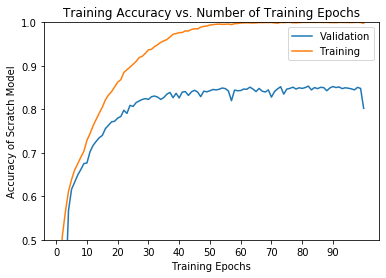

100


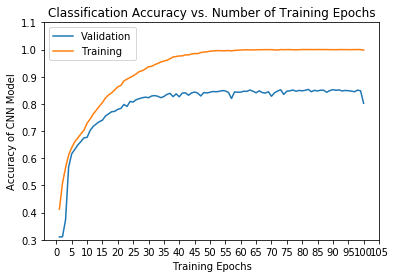

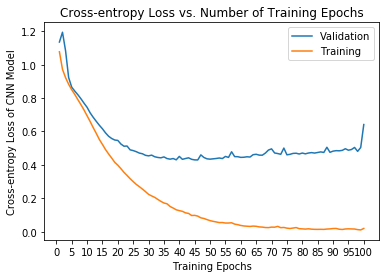

tensor([[580.,  30.,  28.],
        [ 44., 549.,  70.],
        [ 40.,  89., 624.]])
[664. 668. 722.]
[[0.90909094 0.04702194 0.04388715]
 [0.06636501 0.8280543  0.10558069]
 [0.05312085 0.11819389 0.8286853 ]]



Fold- 4 : Initializing Datasets and Dataloaders...
Epoch 0/99
----------
LR 5e-06
train Loss: 1.1614 Acc: 0.4074
train Bal. Acc: 0.3936
val Loss: 1.1819 Acc: 0.3315
val Bal. Acc: 0.3492
saving best model
Total time: 0:02:47.578000
Epoch time: 2m 48s

Epoch 1/99
----------
LR 5e-06
train Loss: 1.0010 Acc: 0.5581
train Bal. Acc: 0.5606
val Loss: 1.3457 Acc: 0.3101
val Bal. Acc: 0.3328
Total time: 0:05:35.635003
Epoch time: 5m 36s

Epoch 2/99
----------
LR 5e-06
train Loss: 0.9505 Acc: 0.5817
train Bal. Acc: 0.5861
val Loss: 1.2285 Acc: 0.3549
val Bal. Acc: 0.3741
saving best model
Total time: 0:08:24.352004
Epoch time: 8m 24s

Epoch 3/99
----------
LR 5e-06
train Loss: 0.9114 Acc: 0.6018
train Bal. Acc: 0.6047
val Loss: 0.9901 Acc: 0.5312
val Bal. Acc: 0.5390
saving best model


val Loss: 0.3427 Acc: 0.8705
val Bal. Acc: 0.8721
Total time: 1:54:51.125000
Epoch time: 114m 51s

Epoch 41/99
----------
LR 5e-05
train Loss: 0.1209 Acc: 0.9752
train Bal. Acc: 0.9746
val Loss: 0.3358 Acc: 0.8729
val Bal. Acc: 0.8744
Total time: 1:57:39.384999
Epoch time: 117m 39s

Epoch 42/99
----------
LR 5e-05
train Loss: 0.1153 Acc: 0.9783
train Bal. Acc: 0.9777
val Loss: 0.3297 Acc: 0.8768
val Bal. Acc: 0.8780
saving best model
Total time: 2:00:28.011999
Epoch time: 120m 28s

Epoch 43/99
----------
LR 5e-05
train Loss: 0.1047 Acc: 0.9811
train Bal. Acc: 0.9806
val Loss: 0.3387 Acc: 0.8685
val Bal. Acc: 0.8672
Total time: 2:03:14.782000
Epoch time: 123m 15s

Epoch 44/99
----------
LR 5e-05
train Loss: 0.0982 Acc: 0.9830
train Bal. Acc: 0.9827
val Loss: 0.3249 Acc: 0.8793
val Bal. Acc: 0.8796
saving best model
Total time: 2:06:00.539001
Epoch time: 126m 1s

Epoch 45/99
----------
LR 5e-05
train Loss: 0.0929 Acc: 0.9833
train Bal. Acc: 0.9830
val Loss: 0.3270 Acc: 0.8788
val Bal. Ac

train Loss: 0.0242 Acc: 0.9993
train Bal. Acc: 0.9993
val Loss: 0.3952 Acc: 0.8627
val Bal. Acc: 0.8606
Total time: 3:52:05.611105
Epoch time: 232m 6s

Epoch 83/99
----------
LR 1.5625e-06
train Loss: 0.0215 Acc: 0.9991
train Bal. Acc: 0.9992
val Loss: 0.4065 Acc: 0.8656
val Bal. Acc: 0.8702
Total time: 3:54:53.271105
Epoch time: 234m 53s

Epoch 84/99
----------
LR 1.5625e-06
train Loss: 0.0163 Acc: 0.9995
train Bal. Acc: 0.9996
val Loss: 0.3426 Acc: 0.8778
val Bal. Acc: 0.8793
Total time: 3:57:41.389105
Epoch time: 237m 41s

Epoch 85/99
----------
LR 1.5625e-06
train Loss: 0.0179 Acc: 0.9993
train Bal. Acc: 0.9993
val Loss: 0.3500 Acc: 0.8866
val Bal. Acc: 0.8859
Total time: 4:00:29.418105
Epoch time: 240m 29s

Epoch 86/99
----------
LR 1.5625e-06
train Loss: 0.0197 Acc: 0.9994
train Bal. Acc: 0.9994
val Loss: 0.3585 Acc: 0.8793
val Bal. Acc: 0.8821
Total time: 4:03:17.279105
Epoch time: 243m 17s

Epoch 87/99
----------
LR 1.5625e-06
train Loss: 0.0179 Acc: 0.9995
train Bal. Acc: 0.99

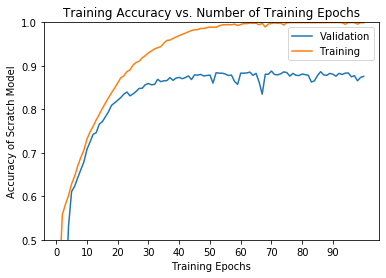

100


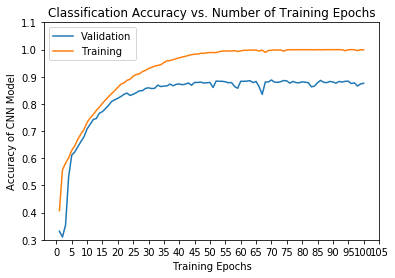

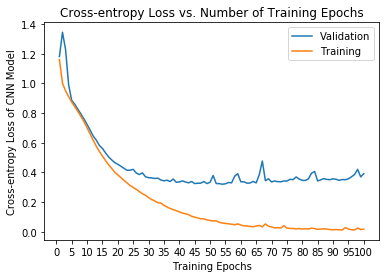

tensor([[590.,  33.,  15.],
        [ 24., 562.,  77.],
        [ 13.,  68., 672.]])
[627. 663. 764.]
[[0.9247649  0.05172414 0.02351097]
 [0.0361991  0.84766215 0.11613876]
 [0.01726428 0.09030545 0.8924303 ]]





In [19]:
# train model 20 times
for runs in range(0,5):
    print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
    #Kfold
    trainpath =[X[i] for i in trainindex[runs]]
    testpath =[X[i] for i in testindex[runs]]
    image_datasets = {}
    image_datasets['train'] = MyDataset(trainpath)
    image_datasets['val'] = MyDataset(testpath)

    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    num_class = 3
    loss_hist_train = []
    
    # Number of epochs to train for
    num_epochs = 100
    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()
    # Initialize the non-pretrained version of the model used for this run
    scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
    scratch_model = scratch_model.to(device)
#     scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.0005, momentum=0.9)
#     scratch_optimizer = optim.Adam(scratch_model.parameters(),lr=0.00001,betas = (0.9, 0.9999),eps=1e-08,weight_decay=0)
    scratch_optimizer = optim.Adam(scratch_model.parameters(),lr=5e-6,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
    scratch_optimizer2 = optim.Adam(scratch_model.parameters(),lr=5e-5,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
    scratch_criterion = nn.CrossEntropyLoss()
    model, scratch_hist_val,scratch_hist_train,loss_hist_train, loss_hist_val,lr_hist,train_Bacc_hist,val_Bacc_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, scratch_optimizer2, num_epochs=num_epochs, is_inception=(model_name=="inception"))

    fname1 = "training_acc_"+str(runs)+".csv"
    np.savetxt(fname1,scratch_hist_train , delimiter=",")
    fname2 = "validation_acc_"+str(runs)+".csv"
    np.savetxt(fname2,scratch_hist_val , delimiter=",")
    fname13 = "training_Bacc_"+str(runs)+".csv"
    np.savetxt(fname13,train_Bacc_hist, delimiter=",")
    fname23 = "validation_Bacc_"+str(runs)+".csv"
    np.savetxt(fname23,val_Bacc_hist, delimiter=",")
    fname20 = "training_loss_"+str(runs)+".csv"
    np.savetxt(fname20,loss_hist_train , delimiter=",")
    fname21 = "validation_loss_"+str(runs)+".csv"
    np.savetxt(fname21,loss_hist_val , delimiter=",")
    fname22 = "learning_rate_"+str(runs)+".csv"
    np.savetxt(fname22,lr_hist , delimiter=",")
    
    shist = []
    shist1 = []

    shist = [h.cpu().numpy() for h in scratch_hist_val]
    shist1 = [h.cpu().numpy() for h in scratch_hist_train]
    print(len(shist))
    plt.title("Training Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy of Scratch Model")
    plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
    plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
    plt.ylim((0.5,1.))
    plt.xticks(np.arange(0, num_epochs, 10.0))
    plt.legend()
    fname3 = 'training_curve_'+str(runs)+'.png'
    plt.savefig(fname3)
    plt.show()

    shist = [h.cpu().numpy() for h in scratch_hist_val]
    shist1 = [h.cpu().numpy() for h in scratch_hist_train]
    print(len(shist))
    plt.title("Classification Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy of CNN Model")
    plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
    plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
    plt.ylim((0.3,1.1))
    plt.xticks(np.arange(0, len(shist)+10, 5.0))
    plt.legend()
    fname3 = 'training_curve_'+str(runs)+'backup'+'.png'
    plt.savefig(fname3)
    plt.show()

    train_loss = [h for h in loss_hist_train]
    val_loss = [h for h in loss_hist_val]
    plt.title("Cross-entropy Loss vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Cross-entropy Loss of CNN Model")
    plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
    plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
    #     plt.ylim((0.5,1.05))
    plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
    plt.legend()
    fname31 = 'loss_curve_'+str(runs)+'.png'
    plt.savefig(fname31)
    plt.show()

    confusion_matrix = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
            inputs = inputs.type(torch.FloatTensor)
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    print(confusion_matrix)
    confusionMat = np.asarray(confusion_matrix)
    sumconfusion = np.sum(confusionMat,axis = 0)
    print(sumconfusion)

    import scipy
    sumconfusion = np.sum(confusionMat,axis = 1).T
    # print(np.tile(sumconfusion,(4,1)))
    summat = np.tile(sumconfusion,(3,1)).T
    # print(test)
    percentconfusion = np.divide(confusionMat,summat)
    print(percentconfusion)
    fname4 = "confusion_Mat_ResNet_confusionMat_"+str(runs)+".csv"
    np.savetxt(fname4,confusionMat , delimiter=",")
    fname5 = "confusion_Mat_ResNet_confusionPer_"+str(runs)+".csv"
    np.savetxt(fname5,percentconfusion , delimiter=",")
    fname6 = 'celltypemodel-ResNet_3D_Run_'+str(runs)+'.pth.tar'

    torch.save(model,fname6)
    print('\n\n')



In [ ]:
fname1 = "training_acc_"+str(runs)+".csv"
np.savetxt(fname1,scratch_hist_train , delimiter=",")
fname2 = "validation_acc_"+str(runs)+".csv"
np.savetxt(fname2,scratch_hist_val , delimiter=",")
fname13 = "training_Bacc_"+str(runs)+".csv"
np.savetxt(fname13,train_Bacc_hist, delimiter=",")
fname23 = "validation_Bacc_"+str(runs)+".csv"
np.savetxt(fname23,val_Bacc_hist, delimiter=",")
fname20 = "training_loss_"+str(runs)+".csv"
np.savetxt(fname20,loss_hist_train , delimiter=",")
fname21 = "validation_loss_"+str(runs)+".csv"
np.savetxt(fname21,loss_hist_val , delimiter=",")
fname22 = "learning_rate_"+str(runs)+".csv"
np.savetxt(fname22,lr_hist , delimiter=",")

shist = []
shist1 = []

shist = scratch_hist_val
shist1 = scratch_hist_train
print(len(shist))
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy of Scratch Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
plt.ylim((0.5,1.))
plt.xticks(np.arange(0, num_epochs, 10.0))
plt.legend()
fname3 = 'training_curve_'+str(runs)+'.png'
plt.savefig(fname3)
plt.show()

shist = [h.cpu().numpy() for h in scratch_hist_val]
shist1 = [h.cpu().numpy() for h in scratch_hist_train]
print(len(shist))
plt.title("Classification Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy of CNN Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
plt.ylim((0.3,1.1))
plt.xticks(np.arange(0, len(shist)+10, 5.0))
plt.legend()
fname3 = 'training_curve_'+str(runs)+'backup'+'.png'
plt.savefig(fname3)
plt.show()

train_loss = [h for h in loss_hist_train]
val_loss = [h for h in loss_hist_val]
plt.title("Cross-entropy Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Cross-entropy Loss of CNN Model")
plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
#     plt.ylim((0.5,1.05))
plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
plt.legend()
fname31 = 'loss_curve_'+str(runs)+'.png'
plt.savefig(fname31)
plt.show()

confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        classes = classes.to(device)
        _, outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
confusionMat = np.asarray(confusion_matrix)
sumconfusion = np.sum(confusionMat,axis = 0)
print(sumconfusion)

import scipy
sumconfusion = np.sum(confusionMat,axis = 1).T
# print(np.tile(sumconfusion,(4,1)))
summat = np.tile(sumconfusion,(3,1)).T
# print(test)
percentconfusion = np.divide(confusionMat,summat)
print(percentconfusion)
fname4 = "confusion_Mat_ResNet_confusionMat_"+str(runs)+".csv"
np.savetxt(fname4,confusionMat , delimiter=",")
fname5 = "confusion_Mat_ResNet_confusionPer_"+str(runs)+".csv"
np.savetxt(fname5,percentconfusion , delimiter=",")
fname6 = 'celltypemodel-ResNet_3D_Run_'+str(runs)+'.pth.tar'

torch.save(model,fname6)
print('\n\n')

In [ ]:
import seaborn as sns
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.1%}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.tile(np.sum(cf,axis = 0),(3,))]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
#         accuracy  = np.trace(cf) / 3
        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nBalanced Accuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
CellName = ['HEK293','HELA','MCF7']
categories = CellName
make_confusion_matrix(percentconfusion, 
                      #group_names=labels,
                      categories=categories,
                      percent=False,
                      cbar=False,
                      figsize=(4 ,4),
                      cmap='Blues',title = 'ResNet18 - 3D Input')

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model = torch.load('celltypemodel-resnet_80rech_Run_1.pth.tar')
scratch_model_fc = nn.Sequential(*(list(scratch_model.children())[:-1]))
scratch_model_fc = scratch_model_fc.to(device)
scratch_model_fc.eval()

In [ ]:
#testing
image_datasets = {}
test_datasets ={}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(testpath)
image_datasets['val'].__getitem__(0)[0].shape

In [ ]:
# Create training and test dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = scratch_model_fc(inputs).cpu().clone().numpy()
        if i == 0:
            outputlist = outputs
            y = classes.cpu().clone().numpy()
        else:
            outputlist = np.append(outputlist,outputs, axis=0)
            y = np.append(y,classes.cpu().clone().numpy(), axis=0)

In [ ]:
print(len(outputlist))
print(outputlist.shape)
print(y.shape)
outputlist = np.squeeze(outputlist)
print(outputlist.shape)

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE(n_components=2, random_state=0,verbose=1, perplexity=45, learning_rate=200,early_exaggeration = 40, n_iter=4000)
X_2d = tsne.fit_transform(outputlist)
CellName = ['HEK293','HELA','MCF7']

In [ ]:
target_ids = range(len(outputlist))
plt.figure(figsize=(4,4))
colors = 'r', 'g', 'b'
for i, c, label in zip(target_ids, colors, CellName):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1],s=3, c=c, label=label,alpha=0.5)
plt.legend()
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('ResNet18 - 3D Input')
plt.show()